# Turnbull

In [1]:
import numpy as np
import os

import matplotlib.pyplot as plt
%matplotlib inline
plt.style.use('default')
from matplotlib.backends.backend_pdf import PdfPages

In [2]:
%run ../models/iceberg/iceberg.py
%run ../models/metocean/metocean.py
%run ../plotting/plot.py

# Iceberg

In [3]:
chosen_track_ind = 0
iip_berg_df = get_berg_df(chosen_track_ind)
iip_berg_df

,index,ICE-YEAR,BERG_NUMBER,DATE,TIME,LATITUDE,LONGITUDE,METHOD,SIZE,SHAPE,SOURCE,TIMESTAMP
0,6319,2015,21511,6/16/2015,1442,48.16,-50.01,R/V,LG,TAB,GTJZ,2015-06-16 14:42:00
1,6320,2015,21511,6/17/2015,1300,48.09,-50.02,R/V,LG,GEN,GMRS,2015-06-17 13:00:00
2,6321,2015,21511,6/18/2015,1249,48.08,-49.76,VIS,LG,TAB,GTJZ,2015-06-18 12:49:00


In [4]:
iip_berg = Iceberg(iip_berg_df['BERG_NUMBER'].loc[0],
                    iip_berg_df['TIMESTAMP'].dt.to_pydatetime(),
                    iip_berg_df['LATITUDE'].loc[:].tolist(),
                    iip_berg_df['LONGITUDE'].loc[:].tolist(),
                    iip_berg_df['SIZE'].loc[0])

# Metocean

In [5]:
ocean_data = ECMWF_Ocean(min(iip_berg.lons), max(iip_berg.lons),
                         min(iip_berg.lats), max(iip_berg.lats),
                         iip_berg.datetimes[0], iip_berg.datetimes[-1])

In [6]:
ocean_data.filenames

['ftp://data.munroelab.ca/pub/ECMWF/ocean/daily/20150616.nc',
 'ftp://data.munroelab.ca/pub/ECMWF/ocean/daily/20150617.nc',
 'ftp://data.munroelab.ca/pub/ECMWF/ocean/daily/20150618.nc']

In [7]:
atm_data = ECMWF_Atm(min(iip_berg.lons), max(iip_berg.lons),
                     min(iip_berg.lats), max(iip_berg.lats),
                     iip_berg.datetimes[0], iip_berg.datetimes[-1])

In [8]:
atm_data.filenames

['ftp://data.munroelab.ca/pub/ECMWF/atm/daily/sub20150616.nc',
 'ftp://data.munroelab.ca/pub/ECMWF/atm/daily/sub20150617.nc',
 'ftp://data.munroelab.ca/pub/ECMWF/atm/daily/sub20150618.nc']

# Drift

In [9]:
def turnbull_drift(t, dt, vx, vy, x, y, l, w, h, UA, VA, UW, VW):

    Vax = UA
    Vay = VA
    Vcx = UW
    Vcy = VW
        
    Vx = vx
    Vy = vy
        

    
    # calculate air density
    # TODO: effect of temperature and humidity
    rhoa = 1.225 # density of air (kg/m^3)
    rhow = 1027.5  # density of water (kg/m^3)
    rhoi = 850
    Ca = 0.1  # air drag coefficient
    Cw = 2.5    # water drag coefficient
    Cdw = 5.0e-4
    
    Ak = (rhoi/rhow)*(2/np.pi)*(l+w)*h  # from Wagner
    As = ((rhow - rhoi)/rhoi)*Ak   # from Wagner
    
    om = 7.2921e-5  # rotation rate of earth in rad/s
    f = 2*om*np.sin(np.deg2rad(y))  # Coriolis parameter (y is latitude in degrees)

    berg_mass = l*w*h*rhoi
    Ma = 0.5*berg_mass
    
    earth_radius = 6378*1e3


    
    #As = l * 0.1*h  # sail area (maximum width (m) * sail height (m))
    
    # TODO: add skin drag
    Fax = (0.5 * rhoa * Ca * As) * abs(Vax - Vx) * (Vax - Vx)
    Fay = (0.5 * rhoa * Ca * As) * abs(Vay - Vy) * (Vay - Vy)

    
    #Ak = 7*110    # keel area (width (m) * keel depth (m))
    #Ak = l * 0.9*h
    
    
    # TODO: extend to n-layer keel model
    # TODO: add skin drag
    Fwx = (0.5 * rhow * Cw * Ak *abs(Vcx - Vx)*(Vcx-Vx)) +(0)
    Fwy = (0.5 * rhow * Cw * Ak *abs(Vcy - Vy)*(Vcy-Vy)) +(0)
    
    
    # Coriolis force
    Fcx = + f * Vy * berg_mass
    Fcy = - f * Vx * berg_mass
    
    
    # Water pressure gradient
    # Mean water current down to the iceberg keel
    Vwmx = 0
    Vwmy = 0
    
    # acceleration (time-derivative) of Vmw
    Amwx = 0
    Amwy = 0
        
    Fwpx = berg_mass*(Amwx + f*Vwmx)
    Fwpy = berg_mass*(Amwy - f*Vwmy)
    
    
    # Iceberg acceleration
    
    # added mass
                
    ax = (Fax + Fcx + Fwx + Fwpx) / (berg_mass + Ma)
    ay = (Fay + Fcy + Fwy + Fwpy) / (berg_mass + Ma)
    
    vx += dt*ax
    vy += dt*ay
    
    y_new = y + dt*vy*(180/(np.pi*earth_radius))
    x_new = x + dt*vx/(np.cos((((y + y_new)/2)*np.pi)/180))*(180/(np.pi*earth_radius))
    
    return vx, vy, x_new, y_new


# Driver

In [10]:
# Timesteps

t0 = iip_berg.datetimes[0]
tf = iip_berg.datetimes[-1]

t_delta = tf - t0
t_delta_hours = t_delta.days*24 + t_delta.seconds/3600
t_step_hours = 0.1
t_step = timedelta(hours = t_step_hours)
dt = t_step_hours*3600  # timestep in seconds
t_all = []

for i in np.arange(0, t_delta_hours + t_step_hours, t_step_hours):
    new_date = t0 + timedelta(hours=i)
    t_all.append(new_date)



berg_sizes = ['GR', 'BB', 'SM', 'MED', 'LG', 'VLG']
bergs_by_size = []

plot_list = []

for berg_size in berg_sizes:
    

    
    mod_berg = Iceberg(iip_berg_df['BERG_NUMBER'][0],
                        iip_berg_df['TIMESTAMP'].dt.to_pydatetime(),
                        [iip_berg_df['LATITUDE'][0]],
                        [iip_berg_df['LONGITUDE'][0]],
                        berg_size)
    
    
    mod_berg.length = [mod_berg.length]
    mod_berg.width = [mod_berg.width]
    mod_berg.height = [mod_berg.height]
    
    # Iceberg Initial Location
    x0, y0 = mod_berg.lons[0], mod_berg.lats[0]

    # Run number
    run_num = 0
    num_runs = 1

    # Buffer number for bounding spatial box
    buf = 0.5

    # Initialize output dict
    output_dict = {}

    for run_num in range(num_runs):

        # Iceberg Initials
        l0, w0, h0 = mod_berg.length[0], mod_berg.width[0], mod_berg.height[0]
        l0 = l0 + l0*0.1*run_num
        w0 = w0 + w0*0.1*run_num
        h0 = h0 + h0*0.1*run_num
        l, w, h = l0, w0, h0
        x, y = x0, y0
        vx, vy = 0, 0

        print('Run number: {}, h = {}, l = {}, w = {}'.format(run_num, h0, l0, w0))
        
        for t in t_all:
            
                
            t_ocean = nc.date2num(t, 'hours since 1950-01-01 00:00:00.0 00:00', 'standard')
            t_atm = nc.date2num(t, 'hours since 1900-01-01 00:00:00.0 00:00', 'standard')
            
            vau = atm_data.iUA([t_atm, y, x])[0]
            vav = atm_data.iVA([t_atm, y, x])[0]
            vwu = ocean_data.iUW([t_ocean, y, x])[0]
            vwv = ocean_data.iVW([t_ocean, y, x])[0]


            #print('Timestep: {}'.format(t))

            vx, vy, x_new, y_new = turnbull_drift(t, dt, vx, vy, x, y, l, w, h, vau, vav, vwu, vwv) 


            if x_new > max(iip_berg.lons)+buf or x_new < min(iip_berg.lons)-buf or \
               y_new > max(iip_berg.lats)+buf or y_new <= min(iip_berg.lats)-buf:
                # Iceberg out-of-bounds
                print('out-of-bounds')
                break


            else:
                vx, vy, x, y = vx, vy, x_new, y_new
                mod_berg.lons.append(x)
                mod_berg.lats.append(y)



    print("Final time: {}".format(t)) 
    bergs_by_size.append(mod_berg)

Run number: 0, h = 5.0, l = 2.5, w = 2.5
out-of-bounds
Final time: 2015-06-16 14:48:00
Run number: 0, h = 30.0, l = 10.0, w = 10.0
out-of-bounds
Final time: 2015-06-16 14:54:00
Run number: 0, h = 100.0, l = 37.5, w = 37.5
Final time: 2015-06-18 12:54:00
Run number: 0, h = 300.0, l = 90.0, w = 90.0
Final time: 2015-06-18 12:54:00
Run number: 0, h = 600.0, l = 60.0, w = 60.0
Final time: 2015-06-18 12:54:00
Run number: 0, h = 562.5, l = 150.0, w = 150.0
Final time: 2015-06-18 12:54:00


# Plotting

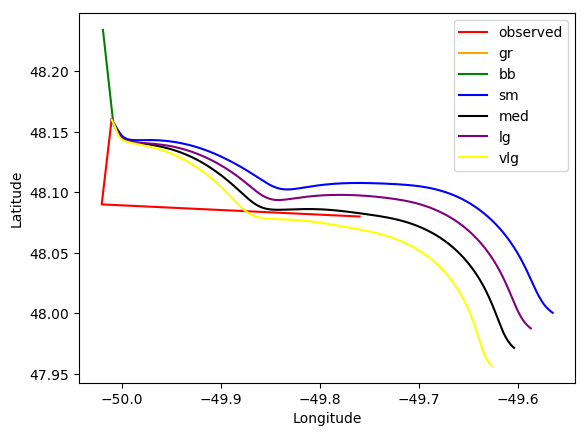

In [11]:
plot = plot_return_size_vary_no_time(iip_berg, bergs_by_size[0], bergs_by_size[1],
                            bergs_by_size[2],bergs_by_size[3],bergs_by_size[4],
                            bergs_by_size[5], chosen_track_ind)

plot_list.append(plot)
if not os.path.exists('plots'):
    os.makedirs('plots')
with PdfPages('plots/plots_size_vary.pdf') as pdf:
    for plot in plot_list:
        pdf.savefig(plot)